# 1 Data and package import

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [50]:
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [51]:
data.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# 2 Data Inspection

## 2.1 Checking data types

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## 2.2 Transforming data

In [53]:
#Change values 0 and 1 to Yes and No in SeniorCitizen for consistent scaling
data['SeniorCitizen'] = data['SeniorCitizen'].map({1:'Yes',0:'No'})

#Change type of TotalCharges from object to numeric
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'],errors='coerce')

## 2.3 Checking levels in categorical variables

In [54]:
for col in data.columns[1:]:
    if data[col].dtype == 'object':
        print(f'{col} {data[col].unique()}')

gender ['Female' 'Male']
SeniorCitizen ['No' 'Yes']
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
PhoneService ['No' 'Yes']
MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn ['No' 'Yes']


## 2.4 Checking missing values

In [55]:
#Check NA´s
data.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [56]:
#Inspect NA´s in dataframe
# data[data.TotalCharges.isna()]

In [57]:
#Insprect total charges when tenure=1
# data[data.tenure == 1]

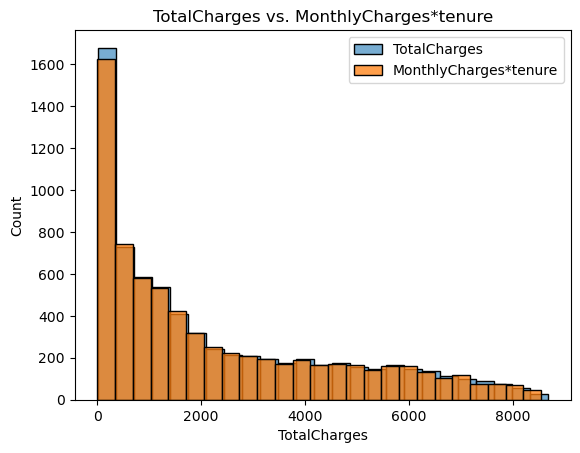

In [58]:
#Relationship total charges with monthlycharges * tenure
sns.histplot(data.TotalCharges,alpha=0.6,label='TotalCharges')
sns.histplot(data.MonthlyCharges*data.tenure,label='MonthlyCharges*tenure')
plt.title('TotalCharges vs. MonthlyCharges*tenure')
plt.legend()
plt.show()

In [59]:
#Replace monthly and total charges values with 0 where tenure = 0
data.loc[data['tenure'] == 0, 'MonthlyCharges'] = 0
data.loc[data['TotalCharges'].isna(), 'TotalCharges'] = 0

All Na´s in total charges have a monthly charges of 0. When you check the total charges with tenure == 1, total charges is the product of monthly charges times tenure. Its unclear why customers with tenure = 0 already have monthly charges when the total charges with tenure = 1 is the same as in monthly charges. Therefore Na´s and monthly charges in tenure = 0 will be replaced by 0.

In [60]:
data.shape

(7043, 21)

## 2.5 Checking duplicates

In [61]:
data.duplicated().sum()

0

## 2.6 Delete reduntant variables

In [62]:
#Delete customerID - reduntant variable
data = data.drop('customerID',axis=1)

# 3 Churn Analysis

## 3.1 Churn Rate

 Customers who have a one year contract churn within their minimal contract duration. Its unclear why. Therefore it is assumend that these customers are outliers and will be deleted for data consistency.

In [63]:
# Proportion of customers with a one year contract, which churn within minimal contract duration
np.divide(data[(data.tenure <= 12) & (data.Churn == 'Yes') & (data.Contract == 'One year')]['Contract'].count(),
          data[(data.Churn == 'Yes') & (data.Contract == 'One year')]['Contract'].count()).round(2)

0.08

In [64]:
# Delete customers with a one year contract and churn within minimal contract duration
data = data[~((data.tenure <= 12) & (data.Churn == 'Yes') & (data.Contract == 'One year'))]

In [65]:
#Total Churn (1st Level)
(data[data.Churn == 'Yes']['Churn'].count() / len(data)).round(2)

0.26

In [66]:
#Total Churn Rate per month
(data[data.Churn == 'Yes']['Churn'].count() / 72).round()


26.0

In [67]:
# Churn Rate per Contract type (2nd Level)
(data[data.Churn == 'Yes']['Contract'].value_counts() / data.Contract.value_counts()).round(2)

Contract
Month-to-month    0.43
One year          0.10
Two year          0.03
Name: count, dtype: float64

## 3.2 Churn by Internet Service and Contract Types

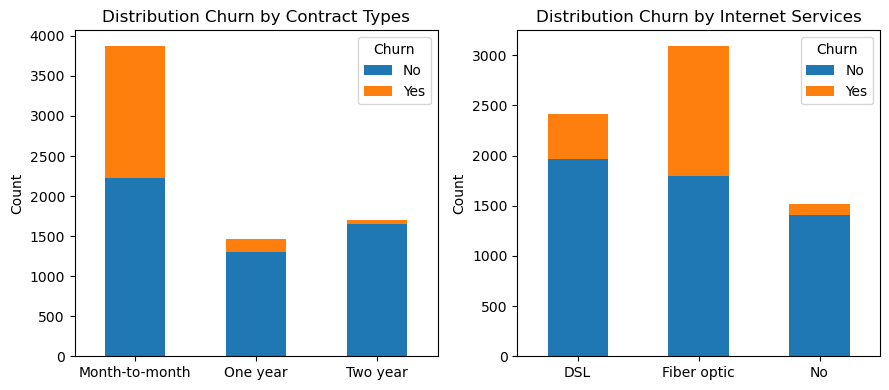

In [68]:
plt.figure(figsize=(9,4))

#Proportion contract types
ax = plt.subplot(1,2,1)
plot_data = data.groupby('Contract')['Churn'].value_counts().unstack()
plot_data.plot.bar(stacked=True,ax=ax)
plt.xticks(rotation=0)
plt.title('Distribution Churn by Contract Types')
plt.xlabel('')
plt.ylabel('Count')


#Proportion Internet Service
ax = plt.subplot(1,2,2)
plot_data = data.groupby('InternetService')['Churn'].value_counts().unstack()
plot_data.plot.bar(stacked=True,ax=ax)
plt.xticks(rotation=0)
plt.title('Distribution Churn by Internet Services')
plt.xlabel('')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [69]:
print(data['Contract'].value_counts(normalize=True).round(2))
print('')
print(data['InternetService'].value_counts(normalize=True).round(2))

Contract
Month-to-month    0.55
Two year          0.24
One year          0.21
Name: proportion, dtype: float64

InternetService
Fiber optic    0.44
DSL            0.34
No             0.22
Name: proportion, dtype: float64


In [70]:
print(data.groupby('Contract')['Churn'].value_counts(normalize=True).round(2))
print('')
print(data.groupby('InternetService')['Churn'].value_counts(normalize=True).round(2))

Contract        Churn
Month-to-month  No       0.57
                Yes      0.43
One year        No       0.90
                Yes      0.10
Two year        No       0.97
                Yes      0.03
Name: proportion, dtype: float64

InternetService  Churn
DSL              No       0.81
                 Yes      0.19
Fiber optic      No       0.58
                 Yes      0.42
No               No       0.93
                 Yes      0.07
Name: proportion, dtype: float64


## 3.3 Churn among tenure

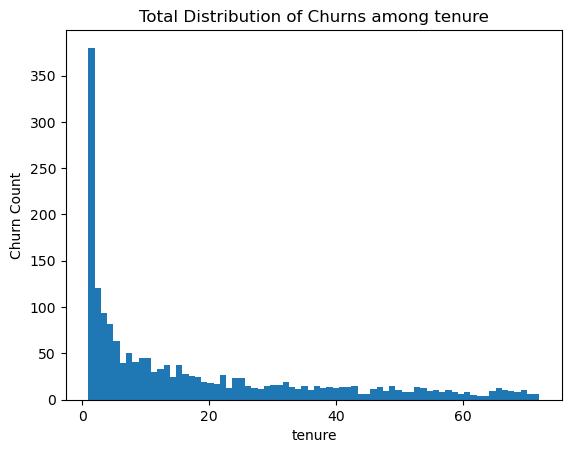

In [71]:
# Distribution churn among tenure
plt.hist(data=data[data.Churn == 'Yes'],x='tenure',bins=72)
plt.xticks(ticks=np.arange(min(data.tenure),max(data.tenure),3))
plt.title('Total Distribution of Churns among tenure')
plt.xlabel('tenure')
plt.ylabel('Churn Count')
plt.xticks(ticks=np.arange(0,72,20))
# plt.grid(linestyle='--')
plt.show()

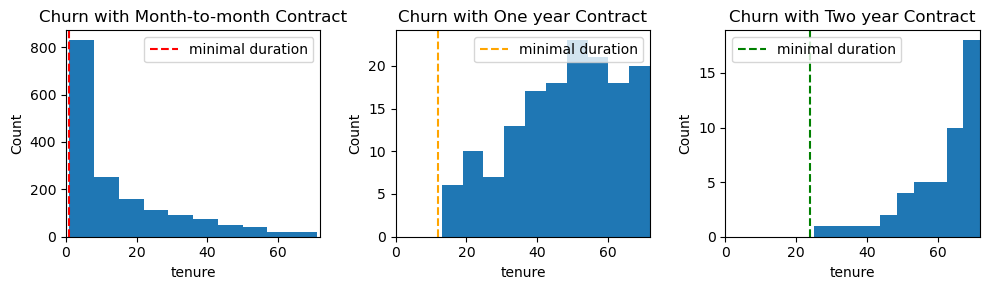

In [72]:
#Churn Distribution among Contract Types and
contract_types = ('Month-to-month','One year','Two year')

plt.figure(figsize=(10,3))
for i, contract_type in enumerate(contract_types):
    plt.subplot(1, 3, i + 1)
    plt.hist(data[(data.Churn == 'Yes') & (data.Contract == contract_type)]['tenure'], bins=10)
    plt.title(f'Churn with {contract_type} Contract')
    plt.xlabel('tenure')
    plt.ylabel('Count')
    plt.xlim(0,72)

    if contract_type == 'Month-to-month':
        plt.axvline(1,color='red',linestyle='--',label='minimal duration')
    elif contract_type == 'One year':
        plt.axvline(12,color='orange',linestyle='--',label='minimal duration')
    else:
        plt.axvline(24,color='green',linestyle='--',label='minimal duration')
    plt.legend()
  
plt.tight_layout()
plt.show()

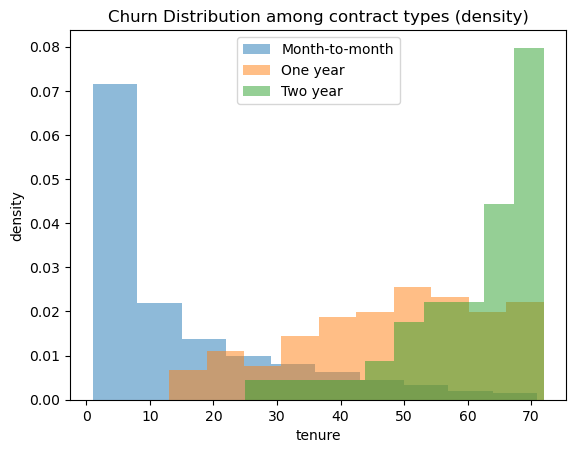

In [73]:
#Churn Distribution among contract types (density)
plt.hist(data=data[(data.Churn == 'Yes') & (data.Contract == 'Month-to-month')],x='tenure',bins=10,density=True,alpha=0.5,label='Month-to-month')
plt.hist(data=data[(data.Churn == 'Yes') & (data.Contract == 'One year')],x='tenure',bins=10,density=True,alpha=0.5,label='One year')
plt.hist(data=data[(data.Churn == 'Yes') & (data.Contract == 'Two year')],x='tenure',bins=10,density=True,alpha=0.5,label='Two year')
plt.title('Churn Distribution among contract types (density)')
plt.legend()
plt.ylabel('density')
plt.xlabel('tenure')

plt.show()

In [74]:
#Decription of contract types
for type in contract_types:
    print(f'{type}')
    print(data[(data.Contract == type) & (data.Churn == 'Yes')]['tenure'].describe().round())

Month-to-month
count    1655.0
mean       14.0
std        16.0
min         1.0
25%         2.0
50%         7.0
75%        21.0
max        71.0
Name: tenure, dtype: float64
One year
count    153.0
mean      48.0
std       16.0
min       13.0
25%       38.0
50%       51.0
75%       60.0
max       72.0
Name: tenure, dtype: float64
Two year
count    48.0
mean     61.0
std      11.0
min      25.0
25%      56.0
50%      66.0
75%      70.0
max      72.0
Name: tenure, dtype: float64


As shown in the description above, churns based on different time periods among the contract types. Customers who have a Month-to-month contract churn within a period of 70 months, customers who have a one year contract within 59 months and customers with a two year contract within 47 months.For this reason, churn among contract types must be defined per month to avoid a biased view.

In [75]:
# Churn Rate per contract type and month (3rd Level)
print('month_to_month_churn_per_month', np.round((1655 / (3875*70))*100,2))
print('one_year_churn_per_month', np.round((166 / (1495*70))*100,2))
print('two_year_churn_per_month', np.round((48 / (1695*47))*100,2))

month_to_month_churn_per_month 0.61
one_year_churn_per_month 0.16
two_year_churn_per_month 0.06


### 3.3.1 Binning tenure to find optimal churn proportion

Text(0.5, 1.0, 'Threshold optimal bin')

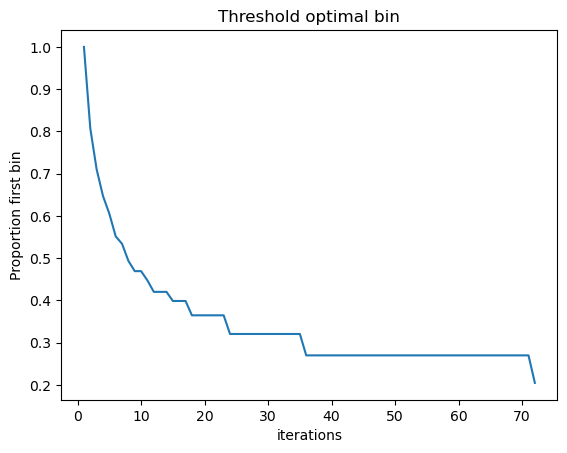

In [76]:
#Finding threshold for optimal bin
data_bins = data.copy()
data_bins = data_bins[data_bins.Churn == 'Yes']

results = []
bins = np.arange(1,73,1)

for i in bins:
    data_bins['tenure_bin'] = pd.cut(x=data_bins['tenure'],bins=i)
    value_counts = data_bins.tenure_bin.value_counts(normalize=True)
    results.append(value_counts.iloc[0])

plt.plot(bins,results)
plt.xlabel('iterations')
plt.ylabel('Proportion first bin')
plt.title('Threshold optimal bin')

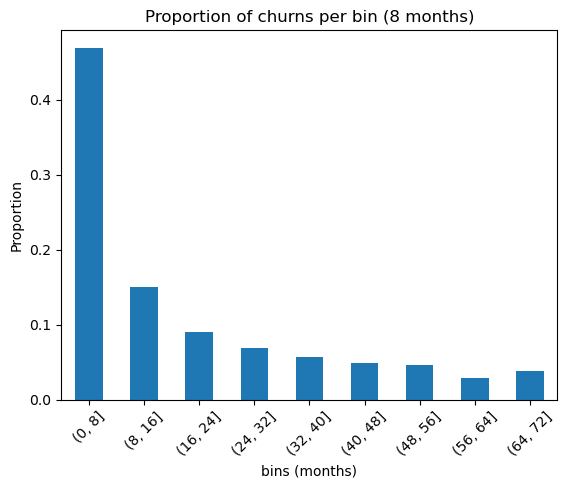

In [77]:
##Binning tenure with practical bin
data_bins['tenure_bin'] = pd.cut(x=data_bins['tenure'],bins=np.arange(0,73,8))

data_bins.tenure_bin.value_counts(normalize=True).sort_index().plot.bar()
plt.title('Proportion of churns per bin (8 months)')
plt.ylabel('Proportion')
plt.xlabel('bins (months)')
plt.xticks(rotation=45)
plt.show()

In [78]:
data_bins.tenure_bin.value_counts(normalize=True).sort_index().round(2)

tenure_bin
(0, 8]      0.47
(8, 16]     0.15
(16, 24]    0.09
(24, 32]    0.07
(32, 40]    0.06
(40, 48]    0.05
(48, 56]    0.05
(56, 64]    0.03
(64, 72]    0.04
Name: proportion, dtype: float64

# 4 Correlation Analysis

## 4.1 Churn by variables with level no internet/phone service

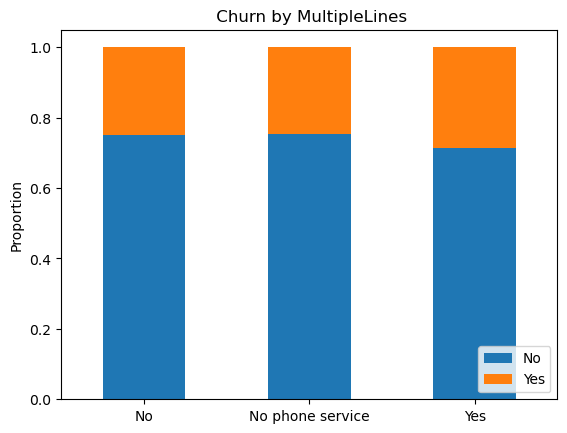

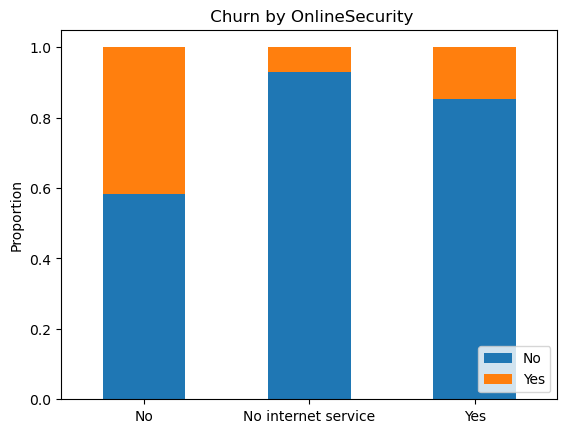

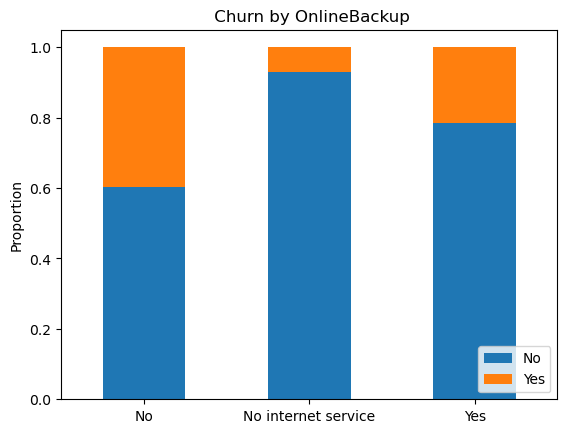

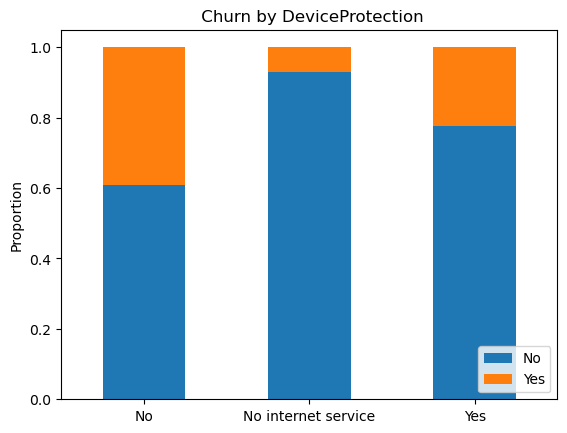

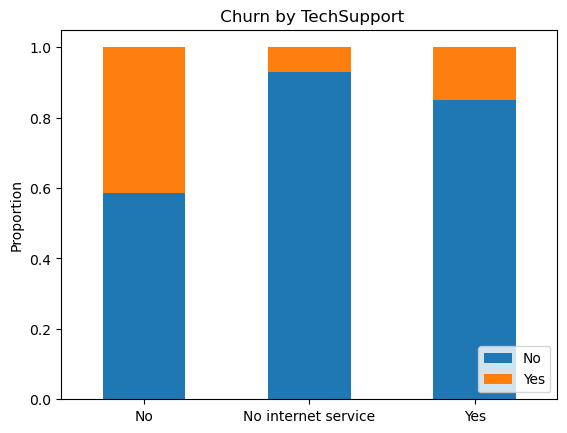

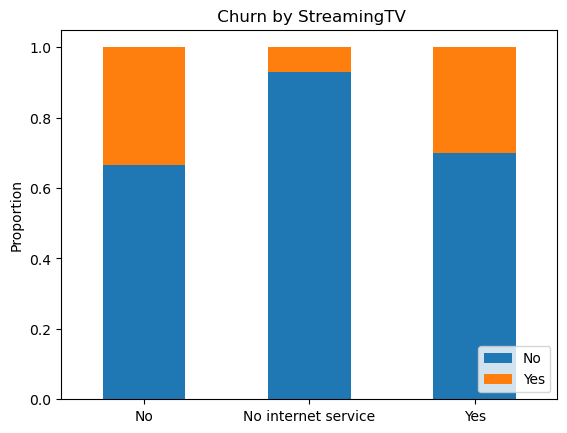

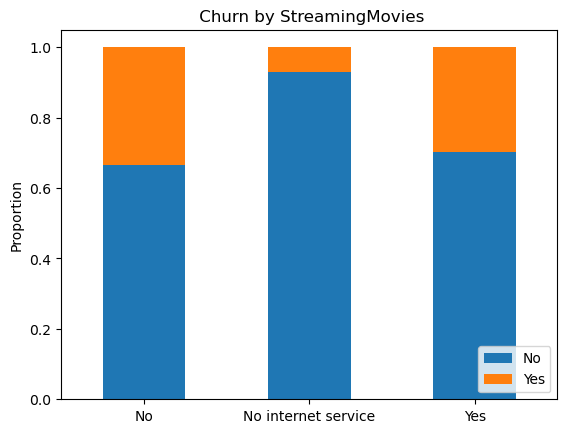

In [79]:
for col in data.columns:
    if data[col].dtype == 'object' and len(data[col].unique()) == 3 and col not in ['InternetService','Contract']:
        data.groupby(data[col])['Churn'].value_counts(normalize=True).unstack().plot.bar(stacked=True)
        plt.title(f' Churn by {col}')
        plt.xlabel('')
        plt.ylabel('Proportion')
        plt.xticks(rotation=0)
        plt.legend(loc='lower right')
        plt.show()

In [80]:
for col in data.columns:
    if data[col].dtype == 'object' and len(data[col].unique()) == 3 and col not in ['InternetService','Contract']:
        print(data.groupby(data[col])['Churn'].value_counts(normalize=True))
        print('')

MultipleLines     Churn
No                No       0.751775
                  Yes      0.248225
No phone service  No       0.752941
                  Yes      0.247059
Yes               No       0.714141
                  Yes      0.285859
Name: proportion, dtype: float64

OnlineSecurity       Churn
No                   No       0.583668
                     Yes      0.416332
No internet service  No       0.928384
                     Yes      0.071616
Yes                  No       0.854311
                     Yes      0.145689
Name: proportion, dtype: float64

OnlineBackup         Churn
No                   No       0.602273
                     Yes      0.397727
No internet service  No       0.928384
                     Yes      0.071616
Yes                  No       0.785008
                     Yes      0.214992
Name: proportion, dtype: float64

DeviceProtection     Churn
No                   No       0.609709
                     Yes      0.390291
No internet service  No       0

In [81]:
'''
columns = ['OnlineSecurity', 'OnlineBackup', 'TechSupport', 'DeviceProtection']
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for i, col in enumerate(columns):
    ax = axes[i // 2, i % 2]
    data.groupby(data[col])['Churn'].value_counts(normalize=True).unstack().plot.bar(stacked=True, ax=ax)
    ax.set_title(f'Churn by {col}')  
    ax.tick_params(axis='x', rotation=0)
    ax.set_xlabel('')
    ax.set_ylabel('Proportion')
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

'''

"\ncolumns = ['OnlineSecurity', 'OnlineBackup', 'TechSupport', 'DeviceProtection']\nfig, axes = plt.subplots(2, 2, figsize=(10, 8))\n\nfor i, col in enumerate(columns):\n    ax = axes[i // 2, i % 2]\n    data.groupby(data[col])['Churn'].value_counts(normalize=True).unstack().plot.bar(stacked=True, ax=ax)\n    ax.set_title(f'Churn by {col}')  \n    ax.tick_params(axis='x', rotation=0)\n    ax.set_xlabel('')\n    ax.set_ylabel('Proportion')\n    ax.legend(loc='lower right')\n\nplt.tight_layout()\nplt.show()\n\n"

In [82]:
from scipy.stats import chi2_contingency

# Defining Cramers´s V
def cramersv (x,y):

    #Chi2
    chi2_conting = pd.crosstab(x,y)
    chi2, p, dof, expected = chi2_contingency(chi2_conting)

    #CramersV
    n = chi2_conting.sum().sum()
    r, k = chi2_conting.shape
    m = min(r - 1, k - 1)
    v = np.sqrt(chi2 / (n * m))
    
    return v,p

## 4.2 Correlation Matrix

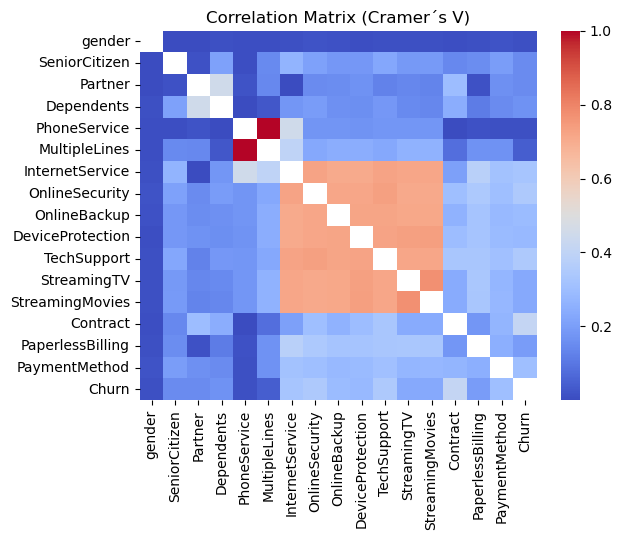

In [83]:
from itertools import combinations

#Select categorical Variables
cat_var_churn = data.select_dtypes(include='object')

#Create empty Dataframe
corr_matrix = pd.DataFrame(index=cat_var_churn.columns, columns=cat_var_churn.columns, dtype=float)

#Iterate throu combinations
for col1, col2 in combinations(cat_var_churn.columns, 2):
    v = cramersv(cat_var_churn[col1], cat_var_churn[col2])

    #Append values to Dataframe
    corr_matrix.loc[col1, col2] = v[0]
    corr_matrix.loc[col2, col1] = v[0]

#Plot
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.ylabel('')
plt.xlabel('')
plt.title('Correlation Matrix (Cramer´s V)')
plt.show()

## 4.3 Correlation Churn by categorical variables

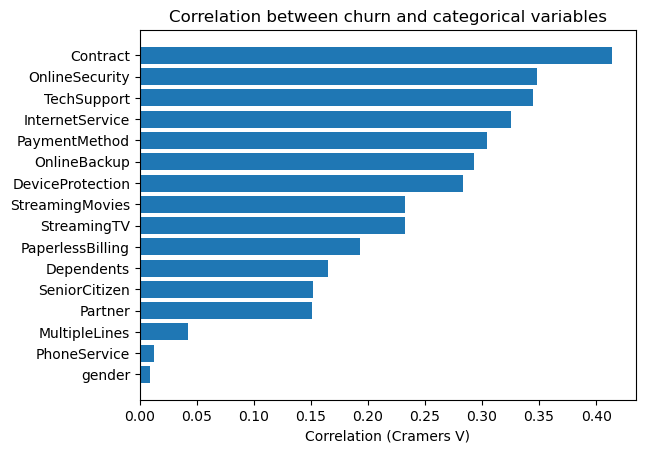

In [84]:
#Create empty list for results
cramersv_churn = []

#Loop thru categorical variables to calculate corr with churn
for col in cat_var_churn.columns:
    if col != 'Churn':
        v,p = cramersv(cat_var_churn[col],cat_var_churn['Churn'])
        cramersv_churn.append({'Variable':col,'CramersV':v,'p value':p})

#Create Dataframe
cramersv_churn_df = pd.DataFrame(cramersv_churn).sort_values(by='CramersV',ascending=False).reset_index(drop=True)

#Plot
plt.barh(data=cramersv_churn_df.sort_values(by='CramersV',ascending=True),width='CramersV',y='Variable')
plt.title('Correlation between churn and categorical variables')
plt.xlabel('Correlation (Cramers V)')
plt.show()

In [85]:
cramersv_churn_df.round(3)

,Variable,CramersV,p value
0,Contract,0.414,0.000
1,OnlineSecurity,0.348,0.000
2,TechSupport,0.344,0.000
3,InternetService,0.325,0.000
4,PaymentMethod,0.304,0.000
5,OnlineBackup,0.293,0.000
6,DeviceProtection,0.283,0.000
7,StreamingMovies,0.233,0.000
8,StreamingTV,0.232,0.000
9,PaperlessBilling,0.193,0.000


low effect: v = 0.1;
medium effect: v= 0.3;
high effect: v= 0.5

## 4.4 Correlation Churn by categorical variables ~ tenure <= 8 months

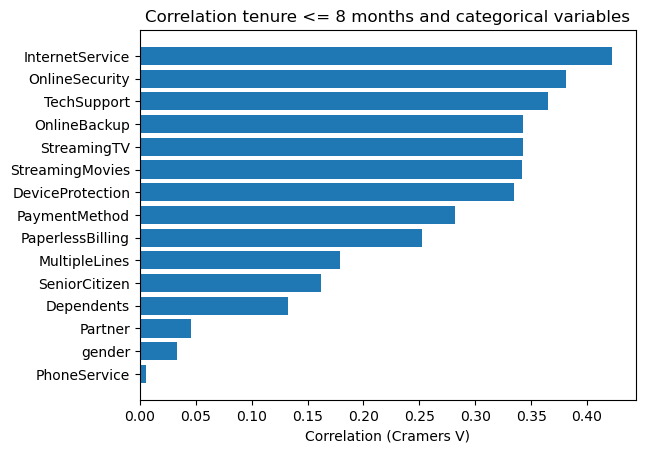

In [86]:
#Filter values <= 8 months
data_filter = data[data['tenure'] <= 8]

#Create empty list for results
cramersv_tenure_class = []

#Loop thru categorical variables to calculate corr with tenure classes
for col in data_filter.columns:
    if col not in ['Churn','Contract'] and data_filter[col].dtype == 'object':
        v,p = cramersv(data_filter[col], data_filter['Churn'])
        cramersv_tenure_class.append({'Variable': col, 'CramersV': v, 'p value':p})

#Create Dataframe
cramersv_tenure_class_df = pd.DataFrame(cramersv_tenure_class).sort_values(by='CramersV', ascending=False).reset_index(drop=True)

#Plot
plt.barh(data=cramersv_tenure_class_df.sort_values(by='CramersV',ascending=True),width='CramersV',y='Variable')
plt.title('Correlation tenure <= 8 months and categorical variables')
plt.xlabel('Correlation (Cramers V)')
plt.show()


In [87]:
cramersv_tenure_class_df.round(3)

,Variable,CramersV,p value
0,InternetService,0.422,0.000
1,OnlineSecurity,0.381,0.000
2,TechSupport,0.365,0.000
3,OnlineBackup,0.342,0.000
4,StreamingTV,0.342,0.000
5,StreamingMovies,0.341,0.000
6,DeviceProtection,0.335,0.000
7,PaymentMethod,0.282,0.000
8,PaperlessBilling,0.253,0.000
9,MultipleLines,0.179,0.000


low effect: v = 0.1;
medium effect: v= 0.3;
high effect: v= 0.5

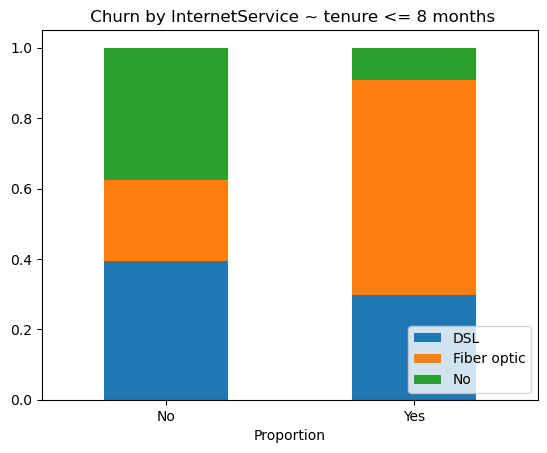

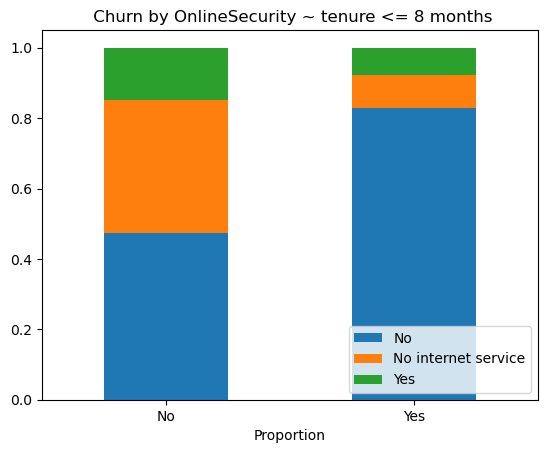

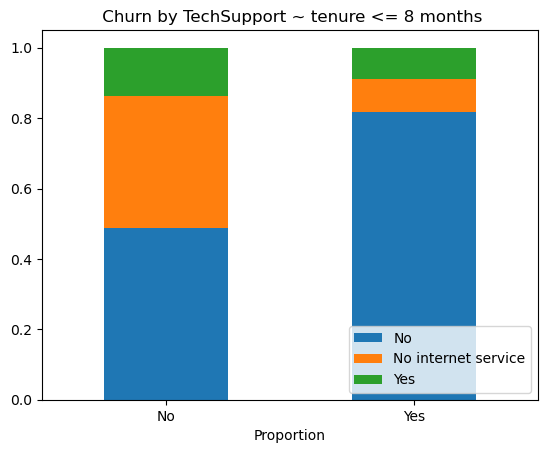

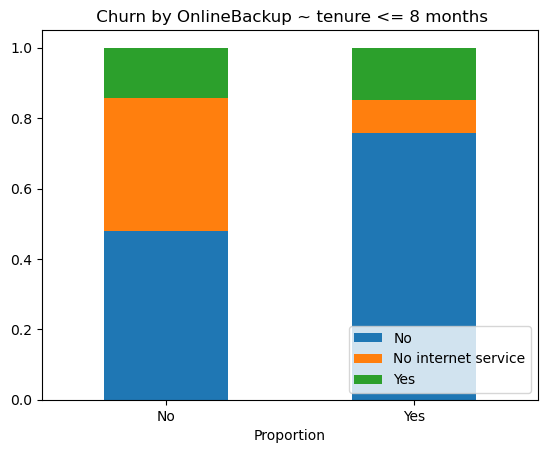

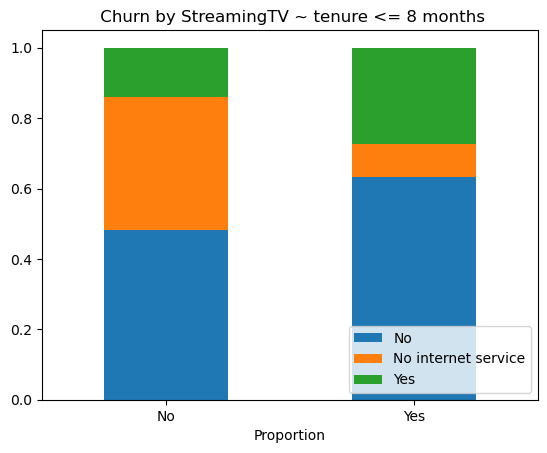

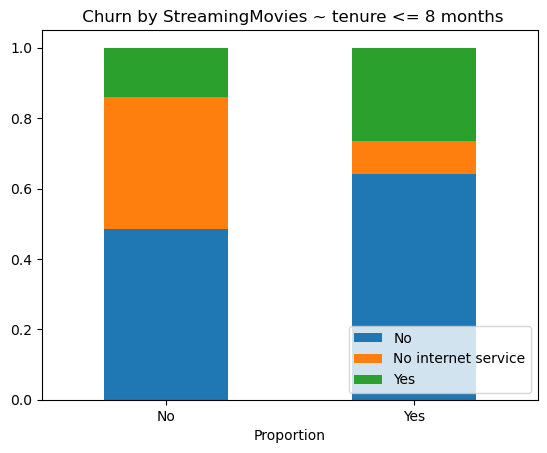

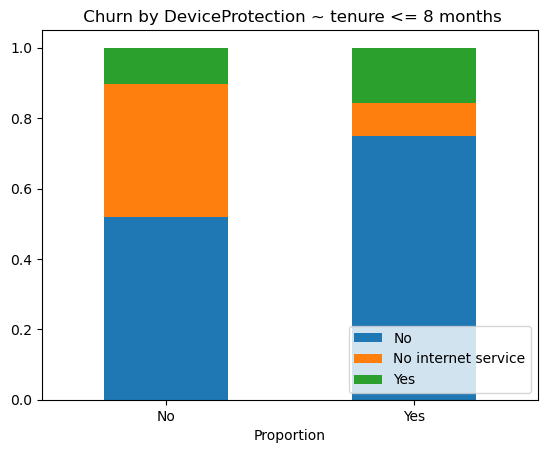

In [88]:
for col in data_filter[['InternetService','OnlineSecurity','TechSupport','OnlineBackup','StreamingTV','StreamingMovies','DeviceProtection']]:
        data_filter.groupby('Churn')[col].value_counts(normalize=True).unstack().plot.bar(stacked=True)
        plt.xlabel('Proportion')
        plt.title(f' Churn by {col} ~ tenure <= 8 months')
        plt.legend(loc='lower right')
        plt.xticks(rotation=0)
        plt.show()

## 4.5 Correlation between tenure <= 8 and > 8 months

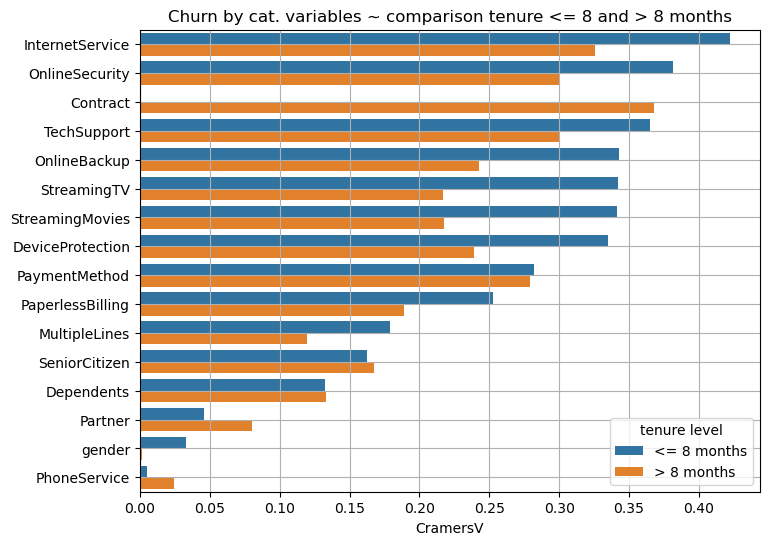

In [89]:
#Filter values > 8 months
data_filter_upper = data[data['tenure'] > 8]

#Create empty list for results
cramersv_tenure_class_upper = []

#Loop thru categorical variables to calculate corr with tenure classes
for col in data_filter_upper.columns:
    if col !=  'Churn' and data_filter_upper[col].dtype == 'object':
        v,p = cramersv(data_filter_upper[col], data_filter_upper['Churn'])
        cramersv_tenure_class_upper.append({'Variable': col, 'CramersV': v, 'p value':p,'tenure level':'> 8 months'})

#Create Dataframe
cramersv_tenure_class_upper_df = pd.DataFrame(cramersv_tenure_class_upper).sort_values(by='CramersV', ascending=False).reset_index(drop=True)

#Concat DataFrames upper and lower
cramersv_tenure_class_lower_df = cramersv_tenure_class_df.copy()
cramersv_tenure_class_lower_df['tenure level'] = '<= 8 months'
cramersv_tenure_class_lower_upper_df = pd.concat([cramersv_tenure_class_upper_df,cramersv_tenure_class_lower_df],axis=0).sort_values(by='CramersV',ascending=False)

#Plot
plt.figure(figsize=(8,6))
sns.barplot(data=cramersv_tenure_class_lower_upper_df,y='Variable',x='CramersV',hue='tenure level')
plt.title('Churn by cat. variables ~ comparison tenure <= 8 and > 8 months')
plt.ylabel('')
plt.grid()
plt.show()

## 4.6 Correlation between has or not has internet service

In [90]:
data['has_internet_service'] = data['OnlineBackup'].apply(lambda x: "No" if x == 'No internet service' else 'Yes')

# 4 Financial Aspects

In [91]:
#Total TotalCharges
data.TotalCharges.sum()

16050464.95

In [92]:
#Statistics TotalCharges by Internet Service
data.groupby('InternetService')['MonthlyCharges'].agg(['sum','mean','median'])

,sum,mean,median
InternetService,,,
DSL,139967.70,57.981649,56.15
Fiber optic,283083.25,91.494263,91.65
No,31957.25,20.996879,20.15


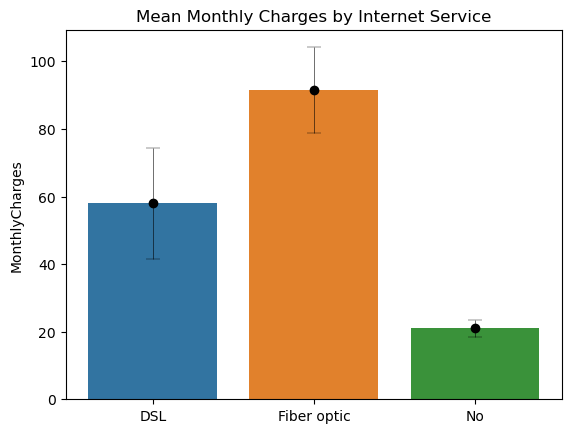

In [93]:
#Mean Monthly Charges by Internet Service
mean = data.groupby('InternetService')['MonthlyCharges'].mean()
std = data.groupby('InternetService')['MonthlyCharges'].std()

sns.barplot(data=data,x='InternetService',y='MonthlyCharges')
plt.errorbar(x=mean.index, y=mean, yerr=std, fmt='o', capsize=5,color='black',capthick=0.3,elinewidth=0.4)
plt.title('Mean Monthly Charges by Internet Service')
plt.xlabel('')
plt.show()

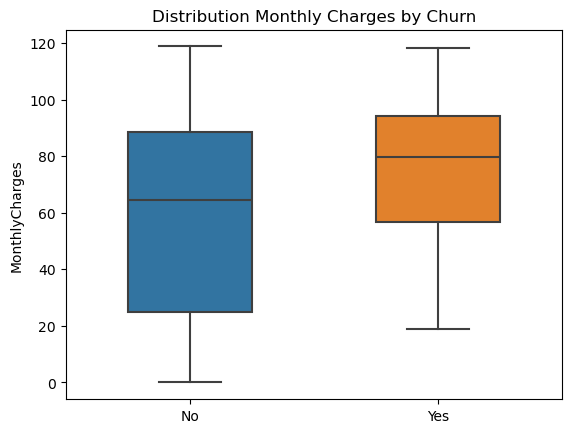

In [94]:
#Distribution Monthly Charges by Churn
sns.boxplot(data=data,x='Churn',y='MonthlyCharges',width=0.5)
plt.title('Distribution Monthly Charges by Churn')
plt.xlabel('')
plt.show()

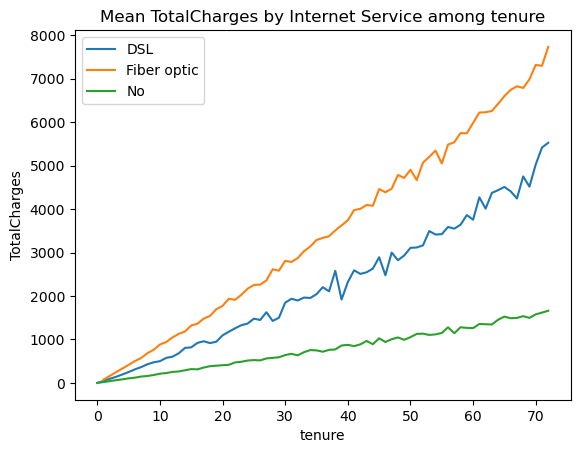

In [95]:
#Mean TotalCharges by Internet Service among tenure
data[data.InternetService == 'DSL'].groupby('tenure')['TotalCharges'].mean().plot(label='DSL')
data[data.InternetService == 'Fiber optic'].groupby('tenure')['TotalCharges'].mean().plot(label='Fiber optic')
data[data.InternetService == 'No'].groupby('tenure')['TotalCharges'].mean().plot(label='No')
plt.title('Mean TotalCharges by Internet Service among tenure')
plt.ylabel('TotalCharges')
# plt.grid()
plt.legend()
plt.show()

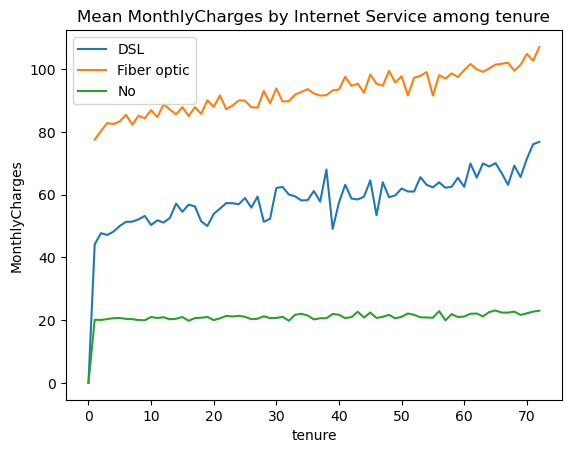

In [96]:
#Mean TotalCharges by Internet Service among tenure
data[data.InternetService == 'DSL'].groupby('tenure')['MonthlyCharges'].mean().plot(label='DSL')
data[data.InternetService == 'Fiber optic'].groupby('tenure')['MonthlyCharges'].mean().plot(label='Fiber optic')
data[data.InternetService == 'No'].groupby('tenure')['MonthlyCharges'].mean().plot(label='No')
plt.title('Mean MonthlyCharges by Internet Service among tenure')
plt.ylabel('MonthlyCharges')
# plt.grid()
plt.legend()
plt.show()